# Importing libraries and initialising data


In [164]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 


In [165]:
print(tf.__version__)

2.10.0


## Getting train and testing data

In [166]:
(x_train, y_train), (x_rem, y_rem) = tf.keras.datasets.fashion_mnist.load_data()

In [167]:
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(60000, 28, 28)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


(None, None)

# Problem Statement

## Implement an image classifier using a deep learning network. 

### X_train and x_test are 28x28 images of fashion items. The y_train and y_test are the labels for the images. 
The labels are integers from 0 to 9. The labels are as follows:
List of labels
| Label       | Description |
| ----------- | ----------- |
| 0           | T-shirt/Top |
| 1           | Trouser     |
| 2           | Pullover    |
| 3           | Dress       |
| 4           | Coat        |
| 5           | Sandal      |
| 6           | Shirt       |
| 7           | Sneaker     |
| 8           | Bag         |
| 9           | Ankle Boot  |


Image dimmensions are 28x28.

The train set and test set are given in two separate datasets.

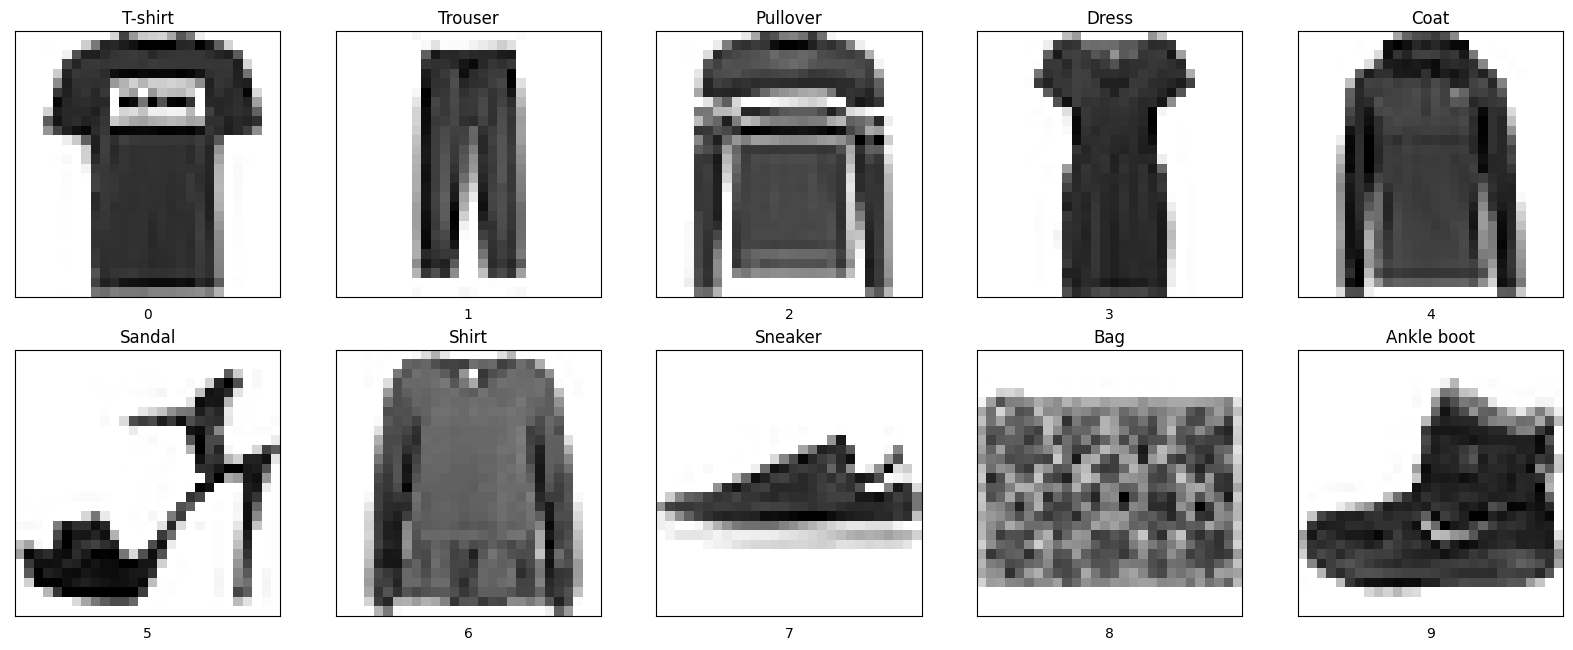

In [168]:
array_of_each_class_position = [1,21,5,20,24,9,18,6,23,0]
# plot all images in array_of_each_class_position
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[i])
    plt.imshow(tf.keras.datasets.fashion_mnist.load_data()[0][0][array_of_each_class_position[i]], cmap=plt.cm.binary)
    plt.xlabel(tf.keras.datasets.fashion_mnist.load_data()[0][1][array_of_each_class_position[i]])
plt.show()

# EDA

## Distribution of Data

In [169]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(pd.DataFrame(y_train, columns=["label"]))

Ankle Boot          :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Trouser             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Bag                 :   6000 or 10.0%


## Normalizing the data

In [170]:
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

# Info for building models

The Sequential model is a linear stack of layers. It can be first initialized and then we add layers using add method or we can add all layers at init stage. The layers added are as follows:

Conv2D is a 2D Convolutional layer (i.e. spatial convolution over images). The parameters used are:

filters - the number of filters (Kernels) used with this layer; here filters = 32;
kernel_size - the dimmension of the Kernel: (3 x 3);
activation - is the activation function used, in this case relu;
kernel_initializer - the function used for initializing the kernel;
input_shape - is the shape of the image presented to the CNN: in our case is 28 x 28 The input and output of the Conv2D is a 4D tensor.
MaxPooling2D is a Max pooling operation for spatial data. Parameters used here are:

pool_size, in this case (2,2), representing the factors by which to downscale in both directions;

Conv2D with the following parameters:

filters: 64;
kernel_size : (3 x 3);
activation : relu;
MaxPooling2D with parameter:

pool_size : (2,2);
Conv2D with the following parameters:

filters: 128;
kernel_size : (3 x 3);
activation : relu;
Flatten. This layer Flattens the input. Does not affect the batch size. It is used without parameters;

Dense. This layer is a regular fully-connected NN layer. It is used without parameters;

units - this is a positive integer, with the meaning: dimensionality of the output space; in this case is: 128;
activation - activation function : relu;
Dense. This is the final layer (fully connected). It is used with the parameters:

units: the number of classes (in our case 10);
activation : softmax; for this final layer it is used softmax activation (standard for multiclass classification)
Then we compile the model, specifying as well the following parameters:

In [171]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout , BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model 1 - Basic CNN (Stupid baseline)

In [172]:
# reshape dataset to have a single channel
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])


In [173]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [174]:
model.fit(x_train,y_train , epochs=10)

model.summary()

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4933 - accuracy: 0.8266
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3692 - accuracy: 0.8663
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3335 - accuracy: 0.8781
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3087 - accuracy: 0.8858
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2912 - accuracy: 0.8934
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2785 - accuracy: 0.8972
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2653 - accuracy: 0.9020
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2545 - accuracy: 0.9054
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2461 - accuracy: 0.9080
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.236

# Model 2 - Adding more layers

## Trying out with batch normalization/dropout

In [175]:
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename=f'accuracy-loss_{train_model}')
    

In [176]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
model_2.add(Dropout(0.2))
model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
model_2.add(Dropout(0.4))
model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.3))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(10, activation='softmax'))

model_2.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

model_2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_86 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_69 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_87 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 28, 28, 24)        6936      
                                                     

In [177]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('best_model2_DO_BN.hdf5', save_best_only = True)
# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [178]:
history = model_2.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Epoch 1/50
235/235 [==============================] - 15s 30ms/step - loss: 0.7876 - accuracy: 0.7173 - val_loss: 1.6445 - val_accuracy: 0.8284
Epoch 2/50
235/235 [==============================] - 7s 29ms/step - loss: 0.4364 - accuracy: 0.8439 - val_loss: 0.5557 - val_accuracy: 0.8858
Epoch 3/50
235/235 [==============================] - 7s 29ms/step - loss: 0.3736 - accuracy: 0.8665 - val_loss: 0.3104 - val_accuracy: 0.8936
Epoch 4/50
235/235 [==============================] - 7s 29ms/step - loss: 0.3415 - accuracy: 0.8770 - val_loss: 0.2823 - val_accuracy: 0.9054
Epoch 5/50
235/235 [==============================] - 7s 29ms/step - loss: 0.3153 - accuracy: 0.8864 - val_loss: 0.2562 - val_accuracy: 0.9038
Epoch 6/50
235/235 [==============================] - 7s 29ms/step - loss: 0.2975 - accuracy: 0.8913 - val_loss: 0.2440 - val_accuracy: 0.9106
Epoch 7/50
235/235 [==============================] - 7s 29ms/step - loss: 0.2840 - accuracy: 0.8964 - val_loss: 0.2349 - val_accuracy: 0.913

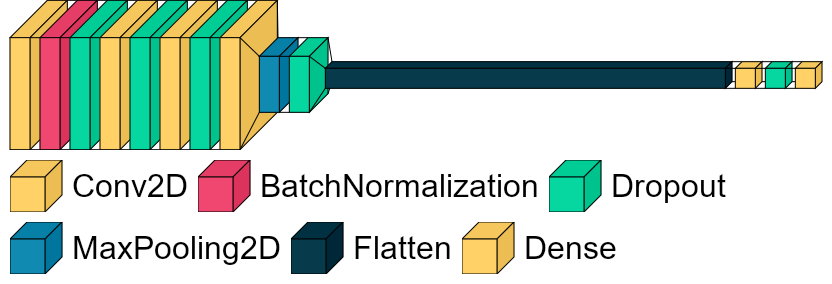

In [179]:
import visualkeras
visualkeras.layered_view(model_2).show()
visualkeras.layered_view(model_2, to_file='output1.png')
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model_2, legend=True, font=font)  # font is optional!

### Visualising model performance

In [180]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



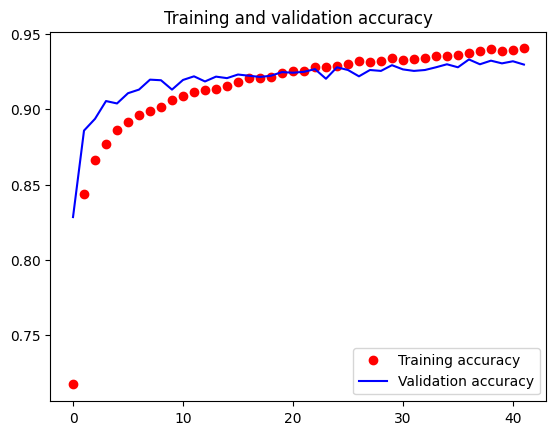

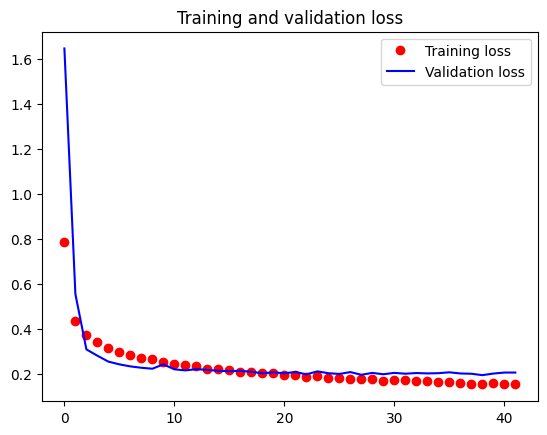

In [181]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [182]:
from sklearn.metrics import confusion_matrix
from itertools import product
from keras.models import load_model
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

#Create Multiclass Confusion Matrix
#Load in the best model state from ModelCheckpoint
cnn_best = load_model('best_model2_DO_BN.hdf5')
#Confirm loss and accuracy on the test data
cnn_best.evaluate(x_test,y_test)
preds = cnn_best.predict(x_test)
preds = np.argmax(np.round(preds),axis=1)
print(preds)


157/157 [==============================] - 1s 5ms/step
[7 9 0 ... 3 7 0]


In [183]:
from sklearn.metrics import classification_report
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
#get the indices to be plotted
correct = np.nonzero(preds==y_test)[0]
incorrect = np.nonzero(preds!=y_test)[0]
target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
print(classification_report(y_test, preds, target_names=target_names))

                    precision    recall  f1-score   support

Item T-shirt/top 0       0.81      0.92      0.86       498
    Item Trouser 1       1.00      0.98      0.99       509
   Item Pullover 2       0.92      0.92      0.92       532
      Item Dress 3       0.94      0.93      0.94       466
       Item Coat 4       0.90      0.92      0.91       502
     Item Sandal 5       1.00      0.98      0.99       491
      Item Shirt 6       0.85      0.76      0.80       501
    Item Sneaker 7       0.97      0.97      0.97       516
        Item Bag 8       0.99      0.98      0.98       488
 Item Ankle Boot 9       0.97      0.97      0.97       497

          accuracy                           0.93      5000
         macro avg       0.93      0.93      0.93      5000
      weighted avg       0.93      0.93      0.93      5000



## Trying out with Dropout Only

In [184]:
model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size=(3, 3),
                activation='relu',
                kernel_initializer='he_normal',
                input_shape=(28,28,1)))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
#loop through the optimizers
model_2.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
    

model_2.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_91 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_73 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_92 (Dropout)        (None, 5, 5, 64)        

In [185]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('best_model2_DO.hdf5', save_best_only = True)

In [186]:
history = model_2.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Epoch 1/50


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 5s 15ms/step - loss: 0.7863 - accuracy: 0.7062 - val_loss: 0.4636 - val_accuracy: 0.8258
Epoch 2/50
235/235 [==============================] - 3s 14ms/step - loss: 0.4796 - accuracy: 0.8230 - val_loss: 0.3770 - val_accuracy: 0.8582
Epoch 3/50
235/235 [==============================] - 3s 14ms/step - loss: 0.4065 - accuracy: 0.8518 - val_loss: 0.3277 - val_accuracy: 0.8786
Epoch 4/50
235/235 [==============================] - 3s 14ms/step - loss: 0.3691 - accuracy: 0.8650 - val_loss: 0.3023 - val_accuracy: 0.8918
Epoch 5/50
235/235 [==============================] - 3s 13ms/step - loss: 0.3397 - accuracy: 0.8759 - val_loss: 0.2842 - val_accuracy: 0.8946
Epoch 6/50
235/235 [==============================] - 3s 14ms/step - loss: 0.3179 - accuracy: 0.8823 - val_loss: 0.2767 - val_accuracy: 0.8982
Epoch 7/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3054 - accuracy: 0.8878 - val_loss: 0.2690 - val_accuracy: 0.9040
Epoch 8/50

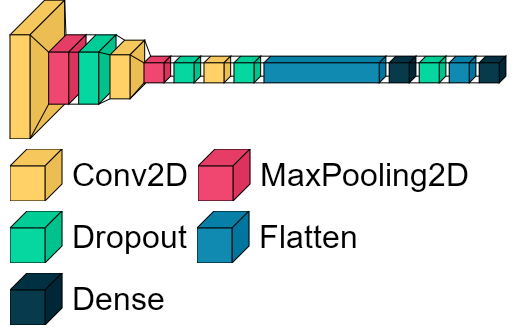

In [187]:
import visualkeras
visualkeras.layered_view(model_2).show()
visualkeras.layered_view(model_2, to_file='output.png')
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model_2, legend=True, font=font)  # font is optional!

In [188]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [189]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [190]:
score = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.25168853998184204
Test accuracy: 0.9088000059127808


### Visualising model performance

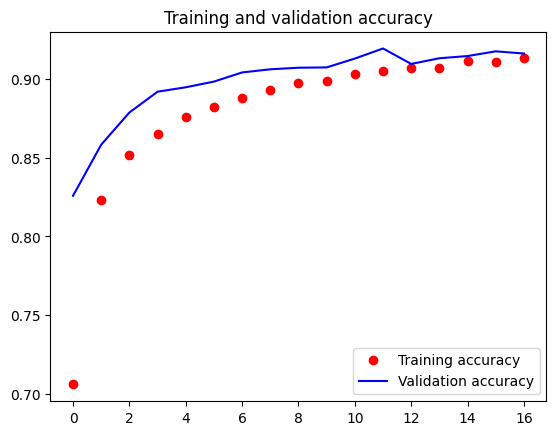

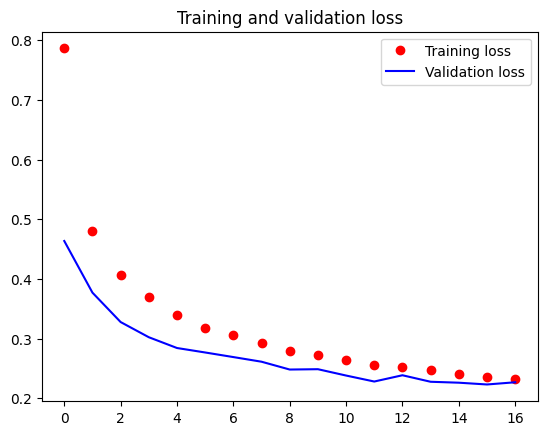

In [191]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Showing performance based on predicted values

In [192]:
y_test

array([7, 9, 0, ..., 3, 7, 0], dtype=uint8)

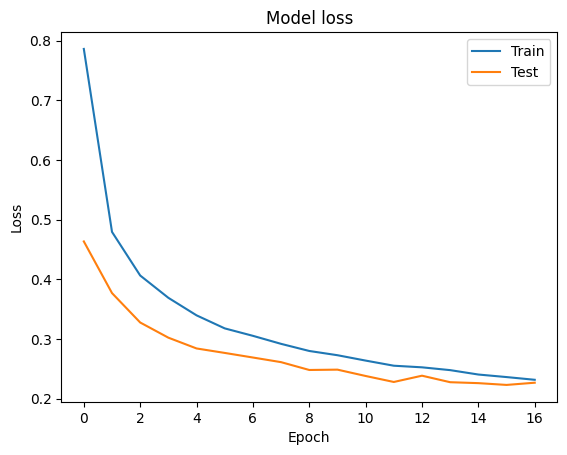

In [193]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()
plot_loss(history.history['loss'], history.history['val_loss'])

In [194]:
#locate index of '1' in each row
cnn_best = load_model('best_model2_DO.hdf5')
#Confirm loss and accuracy on the test data
cnn_best.evaluate(x_test,y_test)
#get the predictions for the test data
preds = cnn_best.predict(x_test)
preds = np.argmax(np.round(preds),axis=1)
print(preds)

157/157 [==============================] - 1s 4ms/step
[7 9 0 ... 3 7 0]


In [195]:
from sklearn.metrics import classification_report
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
#get the indices to be plotted
correct = np.nonzero(preds==y_test)[0]
incorrect = np.nonzero(preds!=y_test)[0]
target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
print(classification_report(y_test, preds, target_names=target_names))

                    precision    recall  f1-score   support

Item T-shirt/top 0       0.73      0.93      0.82       498
    Item Trouser 1       1.00      0.97      0.98       509
   Item Pullover 2       0.86      0.86      0.86       532
      Item Dress 3       0.94      0.88      0.91       466
       Item Coat 4       0.84      0.86      0.85       502
     Item Sandal 5       0.99      0.97      0.98       491
      Item Shirt 6       0.81      0.64      0.72       501
    Item Sneaker 7       0.95      0.97      0.96       516
        Item Bag 8       0.99      0.97      0.98       488
 Item Ankle Boot 9       0.96      0.95      0.96       497

          accuracy                           0.90      5000
         macro avg       0.91      0.90      0.90      5000
      weighted avg       0.91      0.90      0.90      5000



## Correct predictions

C:\Users\Xavier\AppData\Local\Temp\ipykernel_2308\3398885827.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



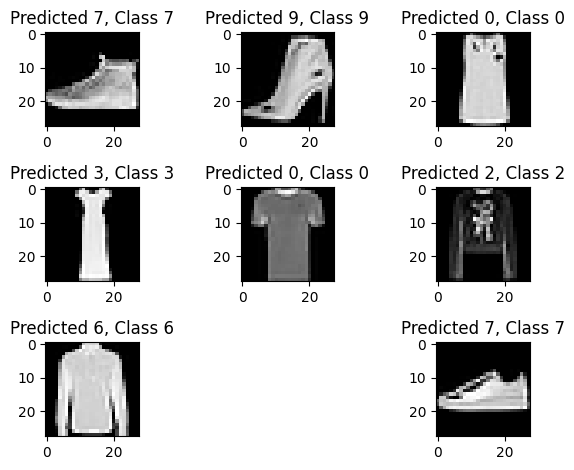

In [196]:
for i, correct_val in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct_val].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(preds[correct_val], y_test[correct_val]))
    plt.tight_layout()

## Incorrect predictions

C:\Users\Xavier\AppData\Local\Temp\ipykernel_2308\398227340.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



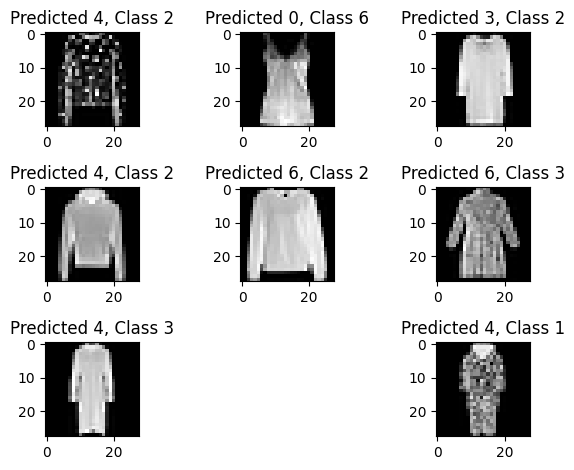

In [197]:
for i, incorrect_val in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect_val].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(preds[incorrect_val], y_test[incorrect_val]))
    plt.tight_layout()

# Tuning Model 2 

### Trying out with data augmentation

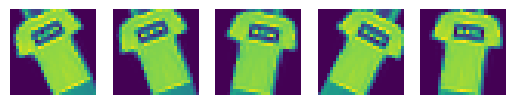

In [198]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,  
    zca_whitening=False,
    rotation_range=50,
    width_shift_range=0.01, 
    height_shift_range=0.01, 
    horizontal_flip=False, 
    vertical_flip=False)

datagen.fit(x_train)

from matplotlib import pyplot as plt

gen = datagen.flow(x_train[1:2], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze())
    plt.plot()
plt.show()

### Model 2 with dropout only

In [199]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(28,28,1)))
    model_2.add(MaxPooling2D((2, 2)))
    model_2.add(Dropout(0.25))
    model_2.add(Conv2D(64, (3, 3), activation='relu'))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Dropout(0.25))
    model_2.add(Conv2D(128, (3, 3), activation='relu'))
    model_2.add(Dropout(0.4))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    model_2.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
        
    model_2.summary()

    return model_2

In [200]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('data_aug_best_model2_DO.hdf5', save_best_only = True)

In [201]:
model_2_data_augmented = model_2_create().fit(x_train, y_train,  
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_95 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_96 (Dropout)        (None, 5, 5, 64)        

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 6s 16ms/step - loss: 0.7865 - accuracy: 0.7077 - val_loss: 0.4657 - val_accuracy: 0.8312
Epoch 2/50
235/235 [==============================] - 3s 13ms/step - loss: 0.4719 - accuracy: 0.8265 - val_loss: 0.3770 - val_accuracy: 0.8658
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.4045 - accuracy: 0.8514 - val_loss: 0.3422 - val_accuracy: 0.8760
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.3661 - accuracy: 0.8663 - val_loss: 0.3221 - val_accuracy: 0.8836
Epoch 5/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3379 - accuracy: 0.8766 - val_loss: 0.2838 - val_accuracy: 0.8982
Epoch 6/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3198 - accuracy: 0.8822 - val_loss: 0.2743 - val_accuracy: 0.9018
Epoch 7/50
235/235 [==============================] - 2s 11ms/step - loss: 0.3032 - accuracy: 0.8887 - val_loss: 0.2622 - val_accuracy: 0.9050
Epoch 8/50

In [202]:
print('Test accuracy:', model_2_data_augmented.model.evaluate(x_test, y_test))

157/157 [==============================] - 1s 5ms/step - loss: 0.2359 - accuracy: 0.9182
Test accuracy: [0.23591265082359314, 0.9182000160217285]


Test loss: 0.23591265082359314
Test accuracy: 0.9182000160217285


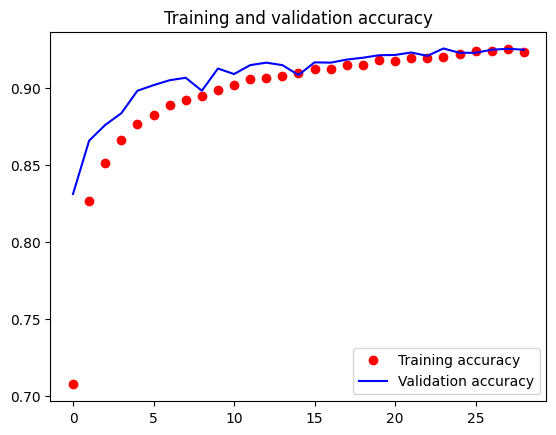

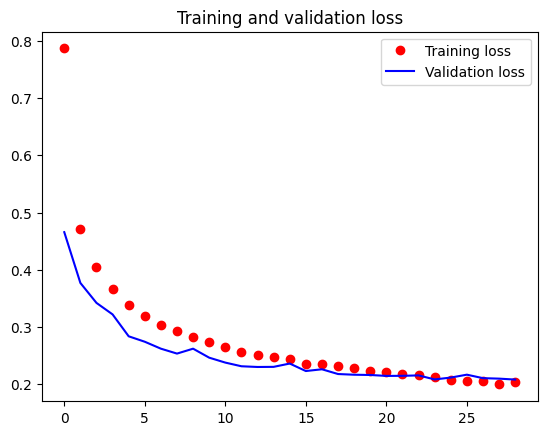

In [203]:
score = model_2_data_augmented.model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
accuracy = model_2_data_augmented.history['accuracy']
val_accuracy = model_2_data_augmented.history['val_accuracy']
loss = model_2_data_augmented.history['loss']
val_loss = model_2_data_augmented.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [204]:
#locate index of '1' in each row
cnn_best = load_model('data_aug_best_model2_DO.hdf5')
#Confirm loss and accuracy on the test data
cnn_best.evaluate(x_test,y_test)
#get the predictions for the test data
preds = cnn_best.predict(x_test)
preds = np.argmax(np.round(preds),axis=1)
print(preds)

157/157 [==============================] - 1s 4ms/step
[7 9 0 ... 3 7 0]


In [205]:
from sklearn.metrics import classification_report
#outputing as classifcation matrix to see the accuracy of each class

labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
#get the indices to be plotted
correct = np.nonzero(preds==y_test)[0]
incorrect = np.nonzero(preds!=y_test)[0]
target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
print(classification_report(y_test, preds, target_names=target_names))

                    precision    recall  f1-score   support

Item T-shirt/top 0       0.78      0.85      0.81       498
    Item Trouser 1       1.00      0.98      0.99       509
   Item Pullover 2       0.90      0.88      0.89       532
      Item Dress 3       0.93      0.91      0.92       466
       Item Coat 4       0.86      0.87      0.87       502
     Item Sandal 5       0.98      0.99      0.98       491
      Item Shirt 6       0.75      0.73      0.74       501
    Item Sneaker 7       0.96      0.99      0.97       516
        Item Bag 8       0.99      0.97      0.98       488
 Item Ankle Boot 9       0.98      0.95      0.97       497

          accuracy                           0.91      5000
         macro avg       0.91      0.91      0.91      5000
      weighted avg       0.91      0.91      0.91      5000



### Model 2 with batchnormalization and dropout

In [206]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.4))
    model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    model_2.add(MaxPooling2D(pool_size=(2,2)))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(10, activation='softmax'))

    model_2.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    model_2.summary()
    return model_2

In [207]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('data_aug_best_model2_DO_BN.hdf5', save_best_only = True)

In [208]:
model_2_data_augmented = model_2_create().fit(x_train, y_train,  
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_99 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_100 (Dropout)       (None, 28, 28, 32)        0         
                                                                 
 conv2d_80 (Conv2D)          (None, 28, 28, 24)        6936      
                                                     

In [ ]:
print('Test accuracy:', model_2_data_augmented.model.evaluate(x_test, y_test))

157/157 [==============================] - 1s 8ms/step - loss: 0.2086 - accuracy: 0.9274
Test accuracy: [0.20860259234905243, 0.9273999929428101]


Test loss: 0.20860259234905243
Test accuracy: 0.9273999929428101


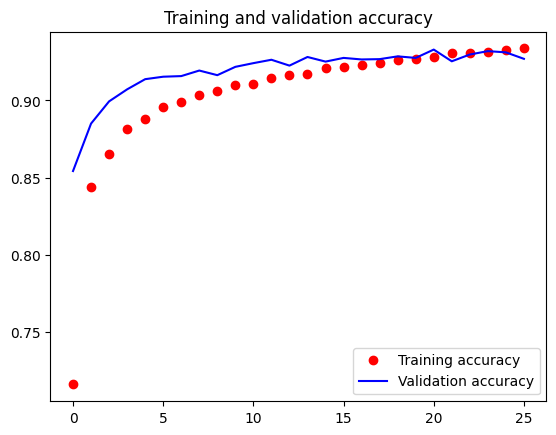

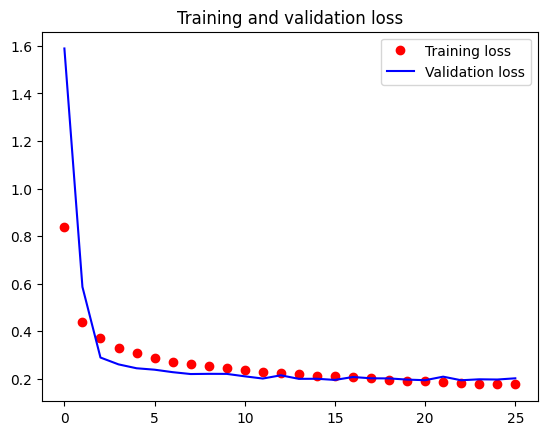

In [ ]:
score = model_2_data_augmented.model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
accuracy = model_2_data_augmented.history['accuracy']
val_accuracy = model_2_data_augmented.history['val_accuracy']
loss = model_2_data_augmented.history['loss']
val_loss = model_2_data_augmented.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
plot_accuracy_and_loss(model_2_data_augmented)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
#locate index of '1' in each row
cnn_best = load_model('data_aug_best_model2_DO_BN.hdf5')
#Confirm loss and accuracy on the test data
cnn_best.evaluate(x_test,y_test)
#get the predictions for the test data
preds = cnn_best.predict(x_test)
preds = np.argmax(np.round(preds),axis=1)
print(preds)

157/157 [==============================] - 1s 5ms/step
[9 2 7 ... 8 5 0]


In [ ]:
from sklearn.metrics import classification_report
#outputing as classifcation matrix to see the accuracy of each class

labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
#get the indices to be plotted
correct = np.nonzero(preds==y_test)[0]
incorrect = np.nonzero(preds!=y_test)[0]
target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
print(classification_report(y_test, preds, target_names=target_names))

                    precision    recall  f1-score   support

Item T-shirt/top 0       0.75      0.88      0.81       475
    Item Trouser 1       1.00      0.99      0.99       478
   Item Pullover 2       0.96      0.86      0.91       528
      Item Dress 3       0.94      0.92      0.93       509
       Item Coat 4       0.88      0.91      0.89       491
     Item Sandal 5       1.00      0.99      1.00       530
      Item Shirt 6       0.81      0.77      0.79       518
    Item Sneaker 7       0.97      0.98      0.97       490
        Item Bag 8       0.99      0.98      0.99       491
 Item Ankle Boot 9       0.98      0.97      0.98       490

          accuracy                           0.92      5000
         macro avg       0.93      0.93      0.93      5000
      weighted avg       0.93      0.92      0.93      5000



## Trying out with l2 regularization

### Model 2 with dropout only

In [ ]:
from keras import regularizers
def model_2_create(l1,l2):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax', activity_regularizer=regularizers.l1(0.01)))
    #loop through the optimizers
    model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])  

    model.summary()
    return model


In [ ]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('regularizer_model_2_DO.hdf5', save_best_only = True)
# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [ ]:
history = model_2_create().fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_82 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_83 (Dropout)        (None, 5, 5, 64)        

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 7s 19ms/step - loss: 0.8063 - accuracy: 0.7026 - val_loss: 0.4696 - val_accuracy: 0.8270
Epoch 2/50
235/235 [==============================] - 4s 18ms/step - loss: 0.4806 - accuracy: 0.8258 - val_loss: 0.3809 - val_accuracy: 0.8642
Epoch 3/50
235/235 [==============================] - 4s 17ms/step - loss: 0.4078 - accuracy: 0.8533 - val_loss: 0.3458 - val_accuracy: 0.8770
Epoch 4/50
235/235 [==============================] - 4s 16ms/step - loss: 0.3654 - accuracy: 0.8697 - val_loss: 0.3173 - val_accuracy: 0.8896
Epoch 5/50
235/235 [==============================] - 4s 16ms/step - loss: 0.3396 - accuracy: 0.8791 - val_loss: 0.3013 - val_accuracy: 0.8908
Epoch 6/50
235/235 [==============================] - 4s 16ms/step - loss: 0.3234 - accuracy: 0.8859 - val_loss: 0.2953 - val_accuracy: 0.8960
Epoch 7/50
235/235 [==============================] - 4s 15ms/step - loss: 0.3056 - accuracy: 0.8924 - val_loss: 0.2768 - val_accuracy: 0.9016
Epoch 8/50

### Model 2 with Batch Normalization

In [ ]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.4))
    model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    model_2.add(MaxPooling2D(pool_size=(2,2)))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(10, activation='softmax'))

    model_2.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    model_2.summary()
    return model_2

## Trying out different optimizers 

In [ ]:
#Get back original x_train,x_test,x_valid
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

(60000, 28, 28, 1)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


In [ ]:
def tune_model_2(optimizer):

    activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])


    model.summary()
    return model

In [ ]:
optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
for i in optimizers:
    model = tune_model_2(i)
    history = model.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))
    model.save('optimizer_model_2_{}.hdf5'.format(i))

NameError: name 'Sequential' is not defined

NameError: name 'tuner' is not defined

# Final Model 2 

# Trying out Model 3 - VGG